In [91]:
%%capture
!pip install rich
! rm -rf celeba_np

In [92]:
import torchvision.datasets
import zipfile
from pathlib import Path
from PIL import Image
import os
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from rich.traceback import install
import torch.nn as nn
import pandas as pd
import re

install()


drive_path = Path('./drive/MyDrive/img_align_celeba.zip')
local_dir = Path("./celeba_np")
local_dir.mkdir(exist_ok=True)

In [93]:
total_img = 20_000
count = 0
pbar = tqdm(total=total_img, unit=" arr")
with pbar:
    with zipfile.ZipFile(drive_path, 'r') as zf:
        for filename in zf.namelist():
            if filename[-4:] == '.jpg':
                ofile = zf.extract(filename)
                img = Image.open(ofile)
                img_arr = np.array(img)
                img_name = '0'*(6 - len(str(count))) + str(count)
                np.save(local_dir / f"{img_name}.npy", img_arr)
                os.remove(ofile)
                count += 1
                pbar.update(1)
                if count == total_img:
                    break


  0%|          | 0/20000 [00:00<?, ? arr/s]

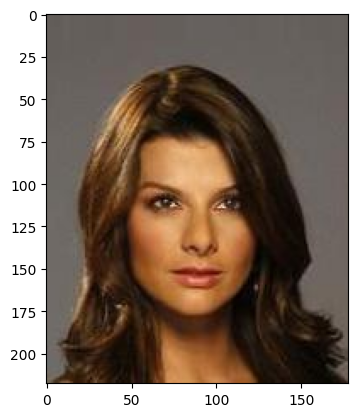

In [97]:
plt.imshow(np.load(local_dir / "000033.npy"))

In [170]:
# dataset

class CelebADataset(Dataset):
    def __init__(self, path="celeba_np"):
        self.folder_path = Path(path) # path relative to current directory
        self.file_path_list = sorted([self.folder_path / f for f in os.listdir(self.folder_path)])
        self.text_idx = {}

    def __len__(self):
        return len(self.file_path_list)

    def __getitem__(self, idx):
        self.text_idx[idx] = self.file_path_list[idx]
        img_arr = np.load(self.file_path_list[idx])
        img_tensor = torch.from_numpy(img_arr) / 255.0
        return img_tensor # no label here

    def plot_image(self, idx):
        img_arr = np.load(self.file_list[idx])
        plt.imshow(img_arr)

In [187]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_random_image(size):
    return torch.rand(size).to(device)

def generate_random_seed(size):
    return torch.randn(size).to(device)

def label_1():
    return torch.tensor([1.0]).to(device)

def label_0():
    return torch.tensor([0.0]).to(device)

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(218*178*3, 200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.loss_fn = nn.BCELoss()
        self.progress = []
        self.count = 0

    def forward(self, x):
        return self.model(x)

    def train(self,input, label):
        output = self.forward(input)
        loss = self.loss_fn(output, label)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.count += 1
        if self.count % 10 == 0:
            self.progress.append(loss.item())

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(marker=".", alpha=0.1, grid=True, figsize=(16, 8))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, 218*178*3),
            nn.Sigmoid(),
            View((218, 178, 3))
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.progress = []
        self.count = 0

    def forward(self, x):
        return self.model(x)

    def train(self, D, random_seed):
        g_output = self.forward(random_seed)
        d_output = D.forward(g_output)
        loss = D.loss_fn(d_output, label_1())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.count += 1
        if self.count % 10 == 0:
            self.progress.append(loss.item())

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(marker=".", alpha=0.1, grid=True, figsize=(16, 8))

In [172]:

D = Discriminator()
D.to(device)
celeba_dataset = CelebADataset()
pbar = tqdm(total=2*len(celeba_dataset))

with pbar:
    for img in celeba_dataset:
        h, w, c = img.shape
        img = img.to(device=device)
        D.train(img, torch.tensor([1.0]).to(device))
        D.train(generate_random_image(img.shape), torch.tensor([0.0]).to(device))
        pbar.update(2)

  0%|          | 0/40000 [00:00<?, ?it/s]

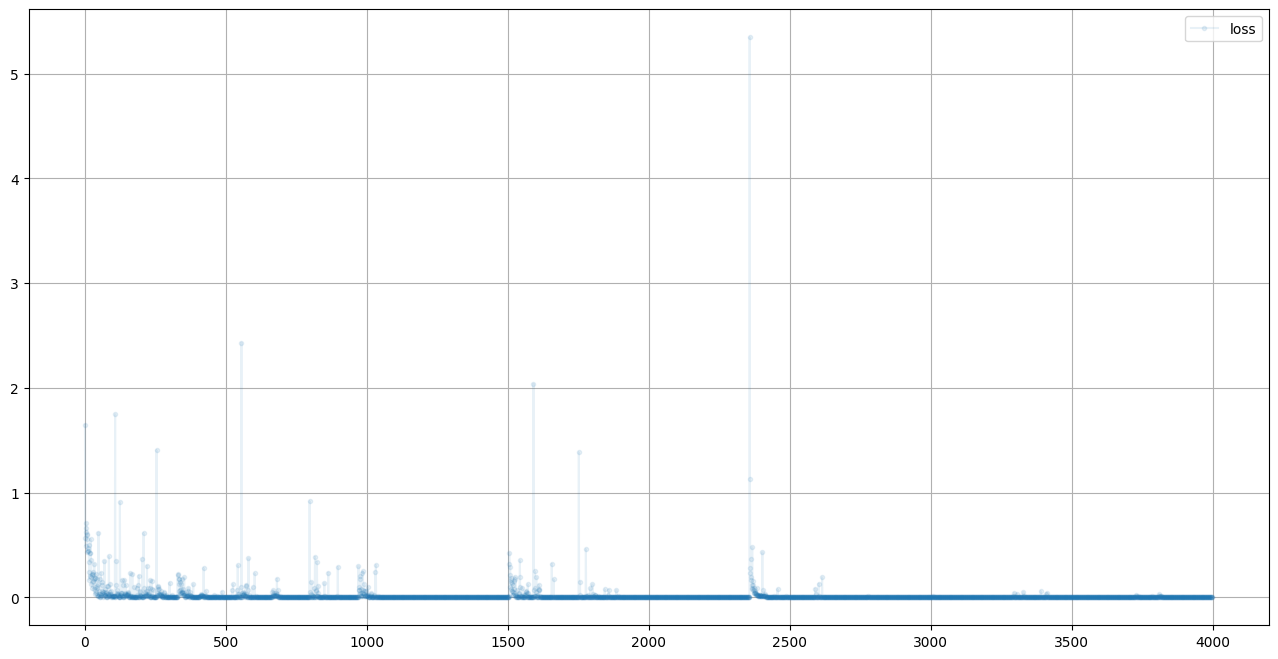

In [173]:
D.plot_progress()

In [176]:
D.forward(celeba_dataset[1].to(device))

tensor([1.0000], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [188]:

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

celeba_dataset = CelebADataset()
pbar = tqdm(total=len(celeba_dataset))

with pbar:
    for img in celeba_dataset:
        h, w, c = img.shape
        img = img.to(device=device)
        D.train(img, label_1())
        fake_img = G.forward(generate_random_seed(100)).detach()
        D.train(fake_img, label_0())
        G.train(D, generate_random_seed(100))
        pbar.update(1)

  0%|          | 0/20000 [00:00<?, ?it/s]

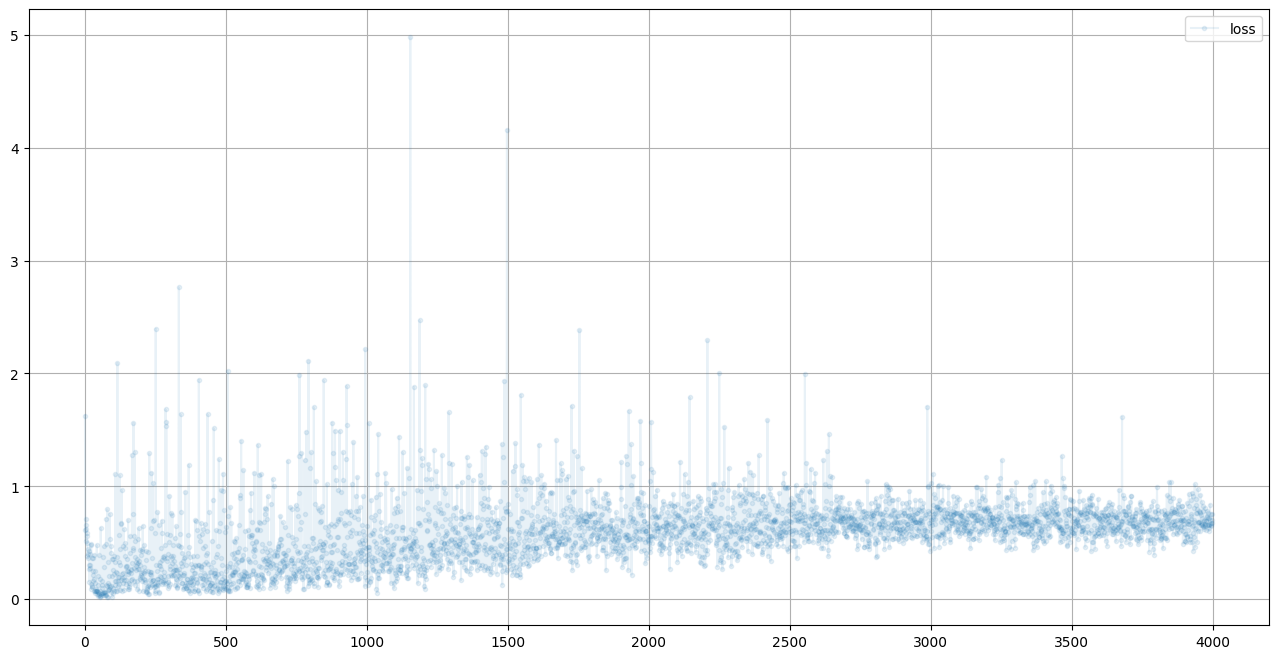

In [189]:
D.plot_progress()

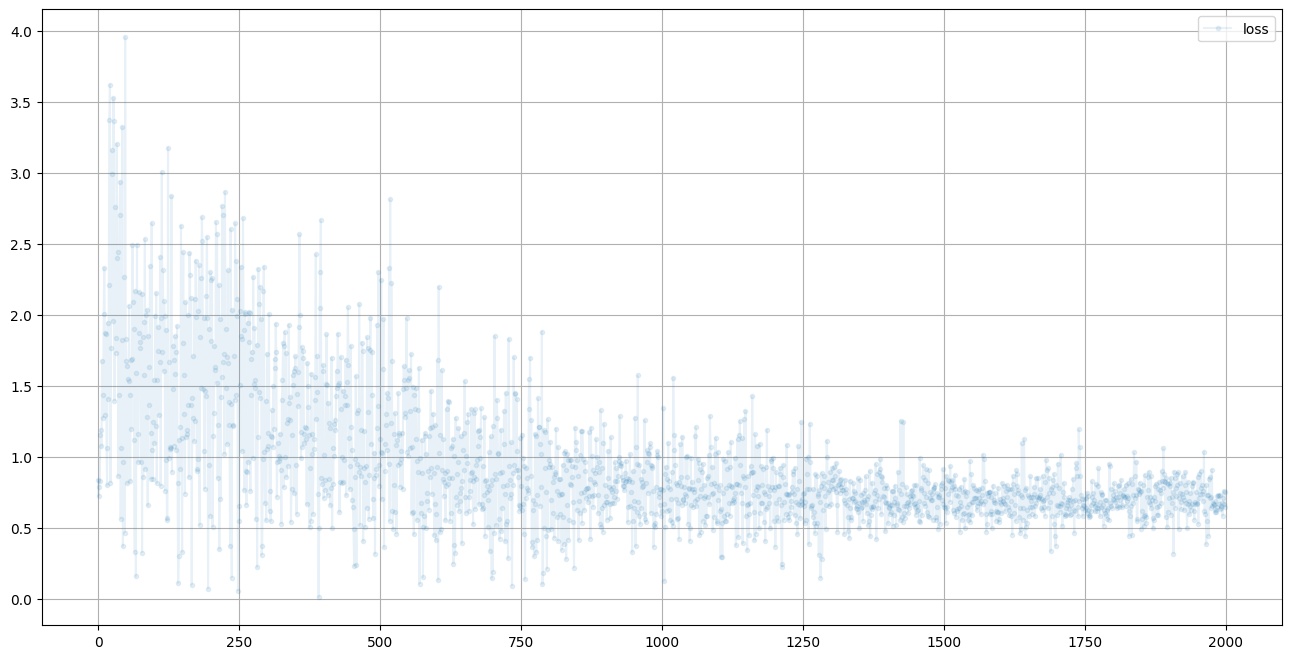

In [190]:
G.plot_progress()

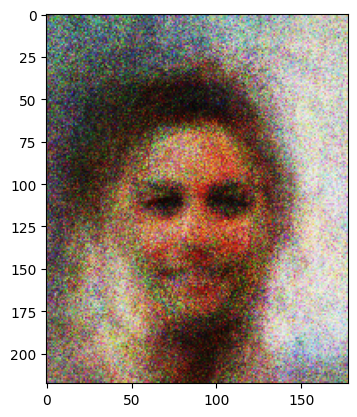

In [207]:
gen_img = G.forward(generate_random_seed(100)).cpu().detach().numpy()
plt.imshow(gen_img)

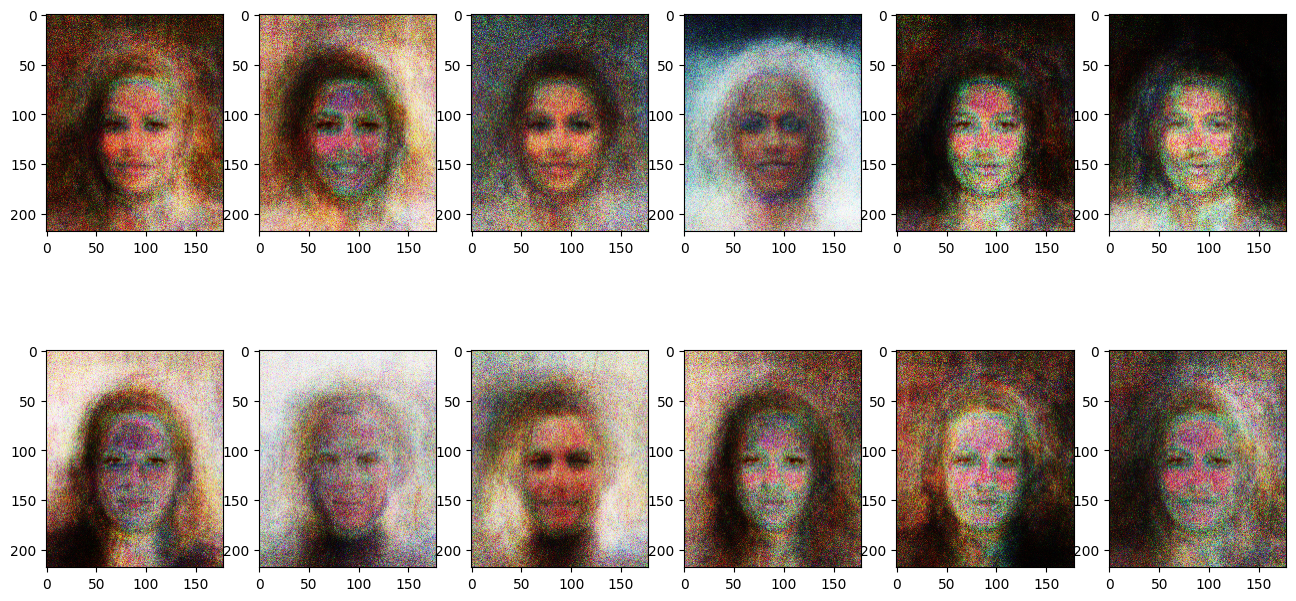

In [216]:
fig, ax = plt.subplots(2, 6, figsize=(16, 8))
for i in range(2):
    for j in range(6):
        gen_img = G.forward(generate_random_seed(100)).cpu().detach().numpy()
        ax[i, j].imshow(gen_img)

In [217]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

celeba_dataset = CelebADataset()
epochs = 6

for i in tqdm(range(epochs), unit=" epoch "):
    for img in tqdm(celeba_dataset, unit=" loop ", leave=True):
        h, w, c = img.shape
        img = img.to(device=device)
        D.train(img, label_1())
        fake_img = G.forward(generate_random_seed(100)).detach()
        D.train(fake_img, label_0())
        G.train(D, generate_random_seed(100))


  0%|          | 0/6 [00:00<?, ? epoch /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

  0%|          | 0/20000 [00:00<?, ? loop /s]

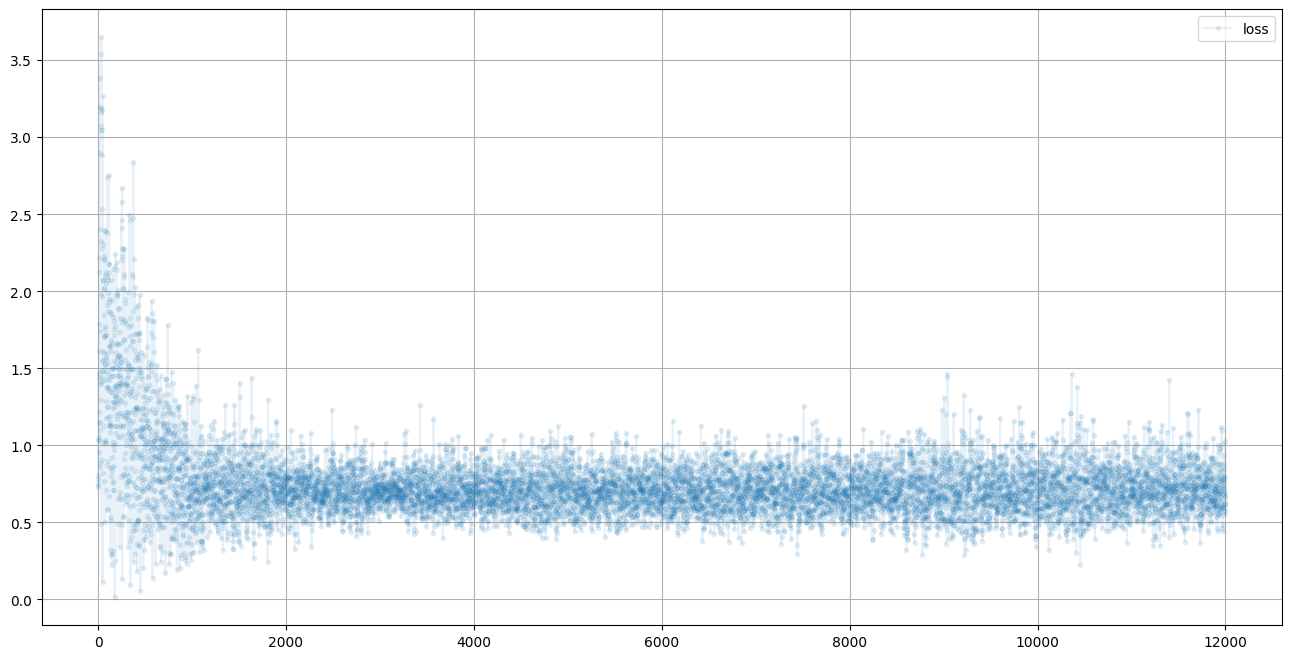

In [222]:
G.plot_progress()

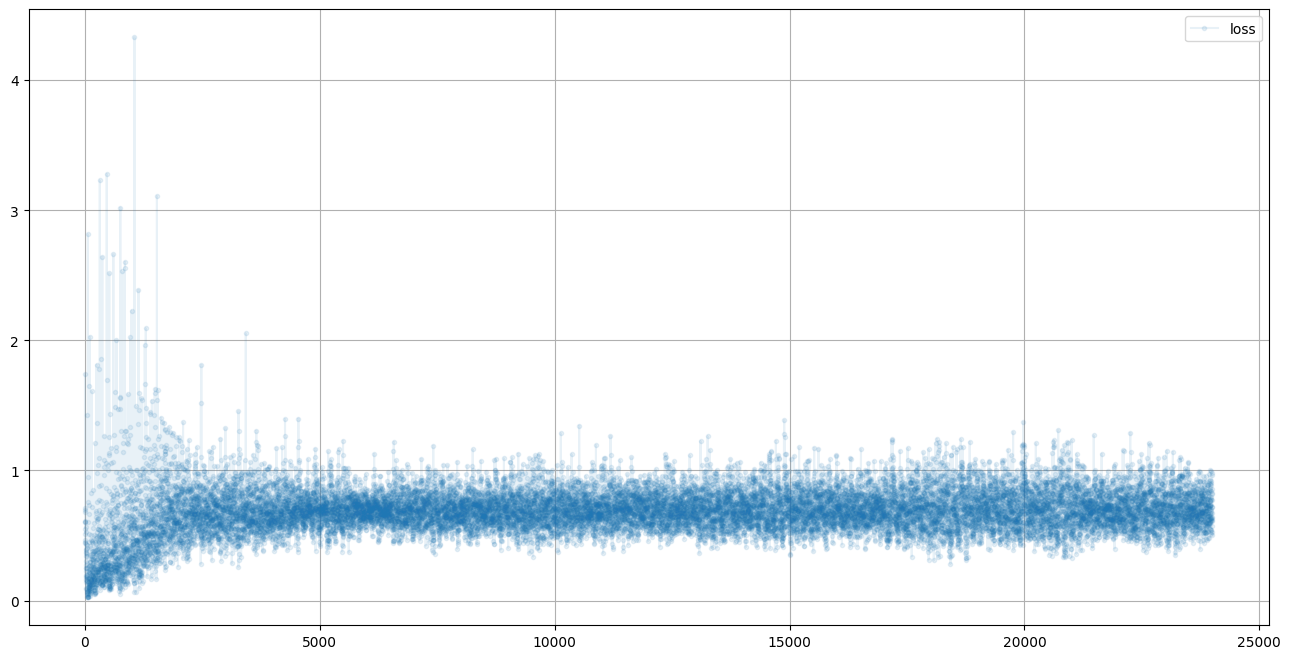

In [223]:
D.plot_progress()

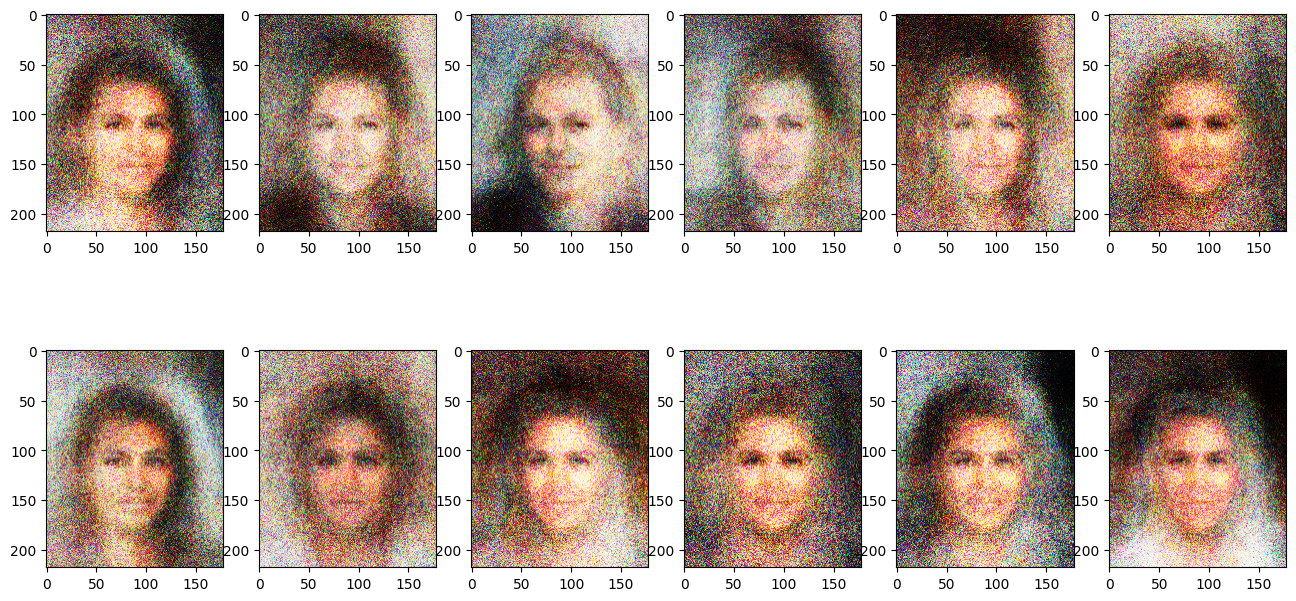

In [228]:
fig, ax = plt.subplots(2, 6, figsize=(16, 8))
for i in range(2):
    for j in range(6):
        gen_img = G.forward(generate_random_seed(100)).cpu().detach().numpy()
        ax[i, j].imshow(gen_img)